In [1]:
import findspark
findspark.init() 

In [2]:
import pyspark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.stat import Correlation
from pyspark.sql.types import IntegerType,BooleanType,DateType,FloatType, StringType
import matplotlib.pyplot as plt 
import seaborn as sns
import pyspark.sql.types as T


In [4]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

def fudf(val):
    return functools.reduce(lambda x, y:x+y, val)

In [8]:
df = spark.read.json('cleaned_dataset')

In [9]:
df.show()

+------------+------------------+------------+-----------+------+--------------------+--------------------+----------------+---+--------+--------+----+----------------+-----------+--------------------+---------------------+-------+--------------+-------+
|acousticness|               age|danceability|duration_ms|energy|              genres|            id_track|instrumentalness|key|liveness|loudness|mode|popularity_track|speechiness|sum_artist_followers|sum_artist_popularity|  tempo|time_signature|valence|
+------------+------------------+------------+-----------+------+--------------------+--------------------+----------------+---+--------+--------+----+----------------+-----------+--------------------+---------------------+-------+--------------+-------+
|       0.658|41.794520547945204|       0.602|     156067| 0.552|[classic czech po...|00AeAaSNbe92PRrst...|             0.0|  0|  0.0972|  -6.667|   1|               3|      0.404|               10807|                   80|182.229|    

# Data Transformation

Vector Assembler. A vector assembler is a transformer that converts a set of features into a single vector column often referred to as an array of features 

In [10]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["duration_ms", "danceability", "loudness", "speechiness","acousticness","energy","instrumentalness","liveness","valence","tempo","time_signature","age"],
    outputCol="features")

df = assembler.transform(df)

Standardizzo i valori del vettore

In [11]:
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df)

# Normalize each feature to have unit standard deviation.
df = scalerModel.transform(df)

In [12]:
df.select('features').show(truncate=False)

+----------------------------------------------------------------------------------------------+
|features                                                                                      |
+----------------------------------------------------------------------------------------------+
|[156067.0,0.602,-6.667,0.404,0.658,0.552,0.0,0.0972,0.65,182.229,3.0,41.794520547945204]      |
|[220133.0,0.77,-7.306,0.172,0.543,0.891,7.96E-4,0.0684,0.898,135.573,4.0,45.797260273972604]  |
|[250960.0,0.212,-6.69,0.14,4.8E-5,0.986,0.918,0.324,0.231,140.917,4.0,25.646575342465752]     |
|[457040.0,0.362,-17.744,0.0398,0.144,0.453,0.827,0.117,0.257,118.853,4.0,31.786301369863015]  |
|[282891.0,0.343,-14.937,0.0384,0.957,0.225,2.49E-4,0.661,0.101,144.533,4.0,4.043835616438356] |
|[217000.0,0.893,-5.331,0.0362,0.119,0.614,9.76E-4,0.0952,0.958,120.021,4.0,13.775342465753425]|
|[545107.0,0.351,-17.481,0.0413,0.96,0.0944,0.0339,0.083,0.237,107.86,4.0,71.81369863013698]   |
|[256933.0,0.422,-3.806,0.0799

variance treshold per eliminare gli attributi con basssa varianza (minore di 1)

In [13]:
from pyspark.ml.feature import VarianceThresholdSelector

selector = VarianceThresholdSelector(varianceThreshold=1,featuresCol='scaledFeatures', outputCol="selectedFeatures")

df = selector.fit(df).transform(df)

print("Output: Features with variance lower than %f are removed." %
      selector.getVarianceThreshold())

Output: Features with variance lower than 1.000000 are removed.


In [14]:
df.select('selectedFeatures').show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------+
|selectedFeatures                                                                                                                        |
+----------------------------------------------------------------------------------------------------------------------------------------+
|[3.6367524459446754,2.2425341538160874,2.1964380167735964,0.0,0.5274762018580149,6.125552254406119,6.364381858546458]                   |
|[4.651660105278073,0.9547422635058588,3.545337450987816,0.0029853342729492913,0.37118695686304753,4.557230165267882,8.485842478061944]  |
|[1.2807168082064304,0.777115795876862,3.9233476169180546,3.4428855057380017,1.7582540061933831,4.73686650881115,8.485842478061944]      |
|[2.1868843611826785,0.22092291911356504,1.8025116333305058,3.101597291116914,0.634925057792055,3.995194299990289,8.485842478061944]     |
|[2.072103137805687,0.21315

PCA sugli attributi continui per trovare nuovi attributi che riassumano (catturando la varianza) quelli presenti


In [15]:
from pyspark.ml.feature import PCA


pca = PCA(k=4, inputCol="selectedFeatures", outputCol="pcaFeatures")
model = pca.fit(df)
df = model.transform(df)

% di varianza spiegata dalle pca features

In [16]:
import numpy as np
np.round(100.00*model.explainedVariance.toArray(),5)

array([22.54319, 18.75416, 16.1346 , 13.68439])

In [17]:
pcs = np.round(model.pc.toArray(),4)
pcs

array([[-0.5125,  0.1901, -0.4717,  0.0614],
       [-0.1381,  0.6976,  0.0291,  0.0543],
       [-0.5727, -0.1982,  0.269 , -0.0718],
       [ 0.4706, -0.1738,  0.0495, -0.3414],
       [-0.092 ,  0.3837,  0.6624, -0.4348],
       [-0.2262, -0.3876,  0.4775,  0.4695],
       [-0.3305, -0.332 , -0.1874, -0.6798]])

In [18]:
import pandas as pd
pcs = np.round(model.pc.toArray(),4)
df_pc = pd.DataFrame(pcs, columns = ['PC1','PC2','PC3','PC4'])
df_pc

,PC1,PC2,PC3,PC4
0,-0.5125,0.1901,-0.4717,0.0614
1,-0.1381,0.6976,0.0291,0.0543
2,-0.5727,-0.1982,0.2690,-0.0718
3,0.4706,-0.1738,0.0495,-0.3414
4,-0.0920,0.3837,0.6624,-0.4348
5,-0.2262,-0.3876,0.4775,0.4695
6,-0.3305,-0.3320,-0.1874,-0.6798


In [19]:
df.select('pcaFeatures').show(truncate=False)

+--------------------------------------------------------------------------------+
|pcaFeatures                                                                     |
+--------------------------------------------------------------------------------+
|[-6.968425963715578,-2.4647201823112255,1.0221145843526416,-1.492352202037453]  |
|[-8.413823459263066,-3.5944880484922104,-0.38116013266030957,-3.708396756870148]|
|[-5.427591874863107,-4.569529261209224,2.480328057283163,-5.645064260804198]    |
|[-4.490100006630161,-4.4492100111579935,0.3511746501891493,-5.210600013851331]  |
|[-5.83668787066902,-2.95956871305103,2.375054455227887,-4.972841996040387]      |
|[-7.954153085150978,-3.5023897007245184,-1.203317439774913,-3.933484917200419]  |
|[-4.939249129506914,-3.5837320170455413,-0.4470010641595419,-4.189664128431549] |
|[-7.05642273480811,-3.7454863951686073,0.22583750634966293,-4.612891897762064]  |
|[-7.7802444680882346,-4.244334205805149,0.23262175640684335,-3.5439003851208333]|
|[-3

Scalo gli attributi numerici con il codice utilizzato nella correlation

# K-Means

In [20]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

confronto silhouette score per scegliere il miglior numero di cluster

In [21]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='pcaFeatures', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='pcaFeatures', k=i)
    
    KMeans_fit=KMeans_algo.fit(df)
    
    output=KMeans_fit.transform(df)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("k={}, Silhouette Score:{}".format(i,score))

k=2, Silhouette Score:0.4047016453650642
k=3, Silhouette Score:0.42649284920081093
k=4, Silhouette Score:0.3813109889358731
k=5, Silhouette Score:0.3060719572462397
k=6, Silhouette Score:0.329357727364433
k=7, Silhouette Score:0.3813679289077209
k=8, Silhouette Score:0.35874617792555946
k=9, Silhouette Score:0.38199386759831244


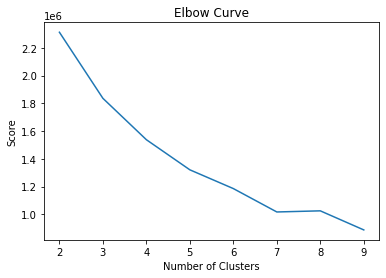

In [22]:
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('pcaFeatures')
    model = kmeans.fit(df)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [23]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='pcaFeatures', k=5)
model = kmeans.fit(df)

# Make predictions
predictions = model.transform(df)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = -0.18981583884207298
Cluster Centers: 
[-6.03056101 -3.345676   -0.43360784 -4.42438504]
[-7.52733698 -3.47723058 -0.38525549 -4.17505917]
[-6.96512061 -3.70102216  1.49544841 -4.24226635]
[-3.98255112 -3.34432663  0.29473437 -4.43150874]
[-7.0090409   0.5742038   0.43638559 -4.07460875]


In [24]:
predictions.select('prediction','genres').show()

+----------+--------------------+
|prediction|              genres|
+----------+--------------------+
|         2|[classic czech po...|
|         1|[afrobeat, afropo...|
|         2|[alternative meta...|
|         3|[corrosion, dark ...|
|         2|[brazilian rock, ...|
|         1|[brazilian rock, ...|
|         0|[classical perfor...|
|         1|                  []|
|         1|[arabesk, turkish...|
|         3| [thai instrumental]|
|         3|[american modern ...|
|         1|[classic swedish ...|
|         1|          [mandopop]|
|         0|[dutch pop, dutch...|
|         1|[chamame, folclor...|
|         1|[europop, new wav...|
|         2|[latin arena pop,...|
|         2|[dominican pop, r...|
|         1|[latin, reggaeton...|
|         1|[argentine indie,...|
+----------+--------------------+
only showing top 20 rows



# Come assegnare il nome di un genere al cluster?

In [38]:
predictions.groupBy("prediction","genres").count().orderBy(desc("prediction"), desc("count")).show(1000, truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|prediction|genres                                                                                                                                                                                                                                                                                         |count|
+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|4         |[hoerspiel]                                                        

In [25]:
prediction_wk1 = predictions.select('prediction', explode(predictions.genres).alias("genre"))

In [40]:
prediction_wk1.groupBy("prediction","genre").count().filter(col("count")>100).orderBy( desc("prediction"), desc("count")).show(4000, truncate=False)

+----------+---------------------------------+-----+
|prediction|genre                            |count|
+----------+---------------------------------+-----+
|4         |hoerspiel                        |10237|
|4         |kleine hoerspiel                 |4662 |
|4         |barnsagor                        |1554 |
|4         |reading                          |1434 |
|4         |barnmusik                        |579  |
|4         |kindermusik                      |548  |
|4         |adult standards                  |292  |
|4         |barnasogur                       |261  |
|4         |psychedelic rock                 |261  |
|4         |hip hop                          |261  |
|4         |rap                              |260  |
|4         |disney horspiele                 |256  |
|4         |barnalog                         |243  |
|4         |vocal jazz                       |223  |
|4         |filmi                            |217  |
|4         |poetry                           |

In [ ]:
p